Today I will be exploring implementing the LIME Text Explainer from scratch, using the original LIME paper as reference (reference)

1. Train a non-interpretable base model (here we will try SVC) on the original dataset
2. Generate a new dataset by perturbing (slightly changing) instances in original dataset
3. Train an interpretable model on the new dataset (eg. Lasso or Ridge)

The weights of the interpretable model become the feature explanations, ie. how much each feature contributes to the prediction of the non-interpretable model

LIME parameters:
Kernel width/similarity kernel
Top features to use, K


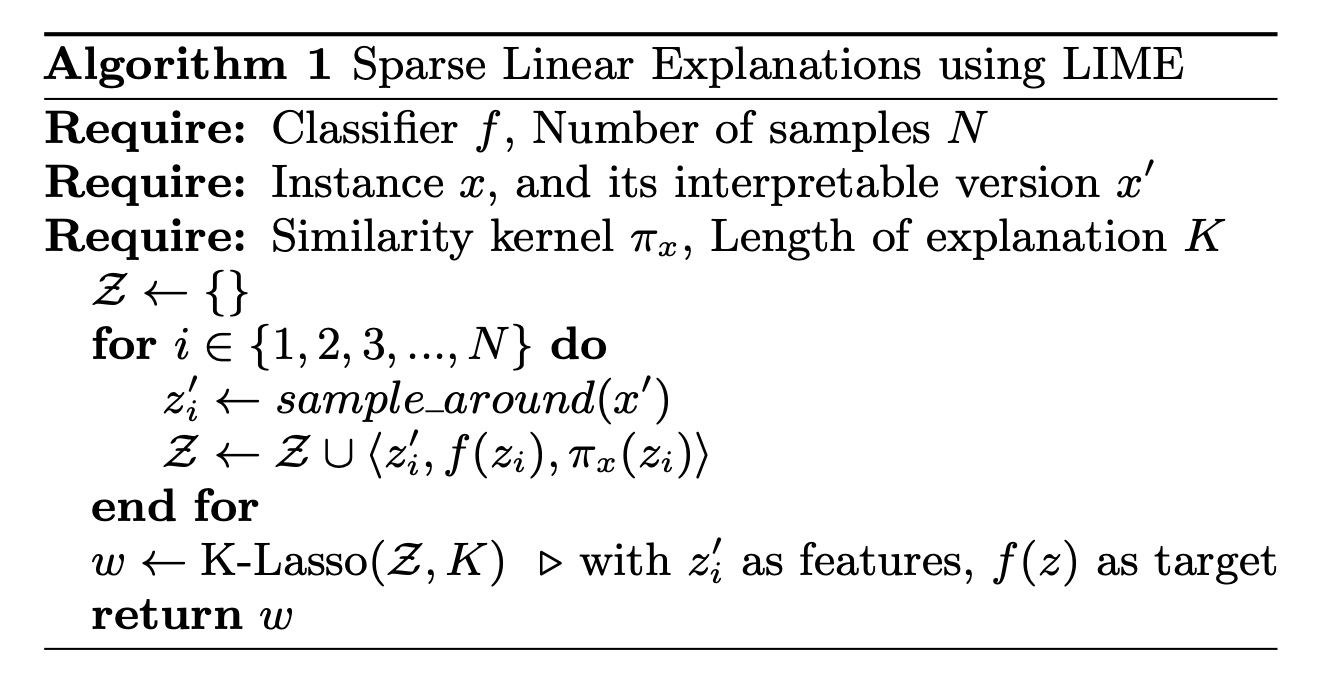

Step 1. We will get our dataset


In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import fetch_20newsgroups

categories = ['rec.sport.hockey', 'sci.med']  # for example
data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
texts = data.data
labels = data.target

Step 2. We will train our non-interpretable SVC model
To vectorize our text inputs, we will use TF-IDF 
- First each string in texts is tokenized 
- Then fit builds a vocabulary dictionary of all unique tokens, assigns each with index 
- Finally transform computes TF-IDF scores for each word, outputs X a sparse matrix (most entries 0) where each row is a doc vector

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=False)
X = vectorizer.fit_transform(texts)
clf = SVC(kernel='rbf', gamma='scale', C=1.0, probability=True).fit(X, labels)

Step 3. We will create our LimeExplainer class
This should do the following:
1. Generate num_samples number of perturbations for the data point x passed in
- Converts the tf-idf vectorized form of data point c into a binary representation, showing absence or presence of a word
- For all non-zero entries, randomly keeps it as 1 or sets it to 0 (for text, we perturb by randomly removing words)
- Use the similarity kernel to calculate sample weights for each perturbed sample
    


In [ ]:
import numpy as np

class LimeExplainer:
    def generate_perturbation_set(self, x, xdash) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        pass
    def generate_explanation(self, x, xdash) -> np.ndarray:
        pass

Step 4. Create helper functions to calculate similarity kernel. This is a function that weights perturbations based on how close they are to the original instance x - closer/more similar ones receive a higher weight

Lime authors define the similarity kernel as:
πx(z) = exp(−D(x,z)2/σ2) 
Where D is a distance function that depends on the task type - for text we can use cosine distance as one option.

The similarity kernel calculation is then used as sampling weights for the surrogate model. The equation for Lasso is shown below. 
πx(z) is a weight to multiple each squared difference



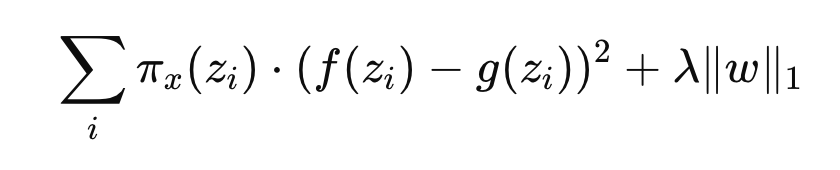

In [ ]:
def similarity_kernel(distance_func, x: np.ndarray, z: np.ndarray, width: float = 0.75) -> float:
    width = width * np.sqrt(np.count_nonzero(x.toarray().flatten()))
    return np.exp(np.negative((distance_func(x.toarray().flatten(),z.values.flatten())**2)) / width**2)

def cosine_distance(A: np.ndarray, B: np.ndarray) -> float:
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    if norm_A == 0 or norm_B == 0:
        print("Norm was 0")
        return 1.0  # max distance if either is all zeros
    cosine_similarity = np.dot(A, B) / (norm_A * norm_B)
    return 1 - cosine_similarity

# Understanding the output

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import explainer, similarity

# Get train data
categories = ['rec.sport.hockey', 'sci.med']  # for example
train_data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
train_texts = train_data.data
train_labels = train_data.target

# Get test data
test_data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
test_texts = test_data.data
test_labels = test_data.target

# Create vectorizer and classifier, fit on training data
vectorizer = TfidfVectorizer(lowercase=False)
X = vectorizer.fit_transform(train_texts)
clf = SVC(kernel='rbf', gamma='scale', C=1.0, probability=True).fit(X, train_labels)

# Create LimeExplainer object
config = explainer.LimeConfig(500)
explainer = explainer.LimeExplainer(similarity.cosine_distance, config)

# Generate explanation for a given datapoint
X_test = vectorizer.transform(test_texts)
idx = 139

# Print chosen text example to explain
print(test_texts[idx])

explanation = explainer.generate_explanation(X_test[idx], clf, vectorizer)
prediction = clf.predict(X_test[idx])
print("Prediction: ", categories[prediction[0]])
print("Actual: ", categories[test_labels[idx]])
for word, weight in explanation:
        print(f"{word}: {weight:.4f}")

I had allergy shots for about four years starting as a sophomore in high
school.  Before that, I used to get bloody noses, nighttime asthma attacks,
and eyes so itchy I couldn't get to sleep.  After about 6 months on the
shots, most of those symptoms were gone, and they haven't come back.  I
stopped getting the shots (due more to laziness than planning) in college.
My allergies got a little worse after that, but are still nowhere near as
bad as they used to be.  So yes, the shots do work.

Completed 0 samples
Completed 100 samples
Completed 200 samples
Completed 300 samples
Completed 400 samples
Prediction:  sci.med
Actual:  sci.med
to: 0.0400
about: 0.0303
used: 0.0274
the: -0.0256
and: 0.0250
work: 0.0219
of: 0.0189
My: 0.0173
asthma: 0.0167
allergies: 0.0131
allergy: 0.0121
sleep: 0.0115
are: 0.0104
attacks: 0.0096
shots: -0.0090
itchy: 0.0090
yes: 0.0086
planning: 0.0078
as: 0.0074
come: -0.0074
months: 0.0061
symptoms: 0.0048
do: 0.0047
nighttime: 0.0047
more: 0.0044
little: 0.004

So our SVM model predicted sci.med, which is the correct answer.

As for our explanation, we get the following top 10 features and their feature importances:

to: 0.0400

about: 0.0303

used: 0.0274

the: -0.0256

and: 0.0250

work: 0.0219

of: 0.0189

My: 0.0173

asthma: 0.0167

allergies: 0.0131

The number values represent how much the word influences the classification prediction in the Lasso surrogate model.
These feature weights are not interpretable on their own, but becoming meaningful in relative terms when compared with the other word weights.

In [2]:
import os
os.chdir('lime-text-explainer')
os.getcwd()

'/Users/lisa-jd/Programming/MinorResearch/lime-text-explainer'